In [2]:
#Basic libraries
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

import requests
import json
import ast
import datetime
from PIL import Image
from io import BytesIO
from datetime import datetime as dt

#Drop future warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

#Sklearn stuff
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score
from imblearn.pipeline import Pipeline as smpipe
from imblearn import FunctionSampler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

### Importing the data

We start out by importing all of our data. Our datasets are from FRED and one is form the University of Michigan. Some of the FRED datasets include the GDP, the unemployment rate and of course the "USREC" which is a boolean value on if there is a recession at the current time.

The data we got from the University of Michigan is a monthly survey where participants were asked wether they would buy large household items like washing machines, stoves, dryers etc.

In [3]:
recession_vs_yield = pd.read_csv('data/preprocessed_2.csv', index_col = 'Date')
recession_vs_yield = recession_vs_yield.set_index(pd.DatetimeIndex(recession_vs_yield.index))
recession_vs_yield = recession_vs_yield.rename(columns= {'Value': 'Unemployment', 'spread': 'Yield spread'})

#Generate the different features
data_mean = recession_vs_yield.resample('Q-JAN', convention='end').agg('mean')
data_mean['USREC'] = data_mean['USREC'].apply(lambda x: 1 if x > 0 else 0)
data_std = recession_vs_yield.resample('Q-JAN', convention='end').agg('std').drop(columns = ['USREC'])
data_split = recession_vs_yield.resample('Q-JAN', convention='end').agg('max') - recession_vs_yield.resample('Q-JAN', convention='end').agg('min')
data_split = data_split.drop(columns = ['USREC']).add_suffix('_split')

#Merge them features
data = pd.merge_asof(data_mean,data_std, left_index = True, right_index = True, suffixes = ('_mean','_std'))
data = pd.merge_asof(data,data_split, left_index = True, right_index = True)
data = data.iloc[1:-1 , :]
data['USREC'] = data['USREC'].shift(periods = -1)
data = data.iloc[:-1,:]

#### US Treasurery Bond datasets
Some other important FRED datasets were the annual interest rates on a 10 year US treasury bond and the annual interest rate on a 3 month US treasury bond. The difference between those two usually is a very good indicator for recession as usually when it goes negative, a recession follows.

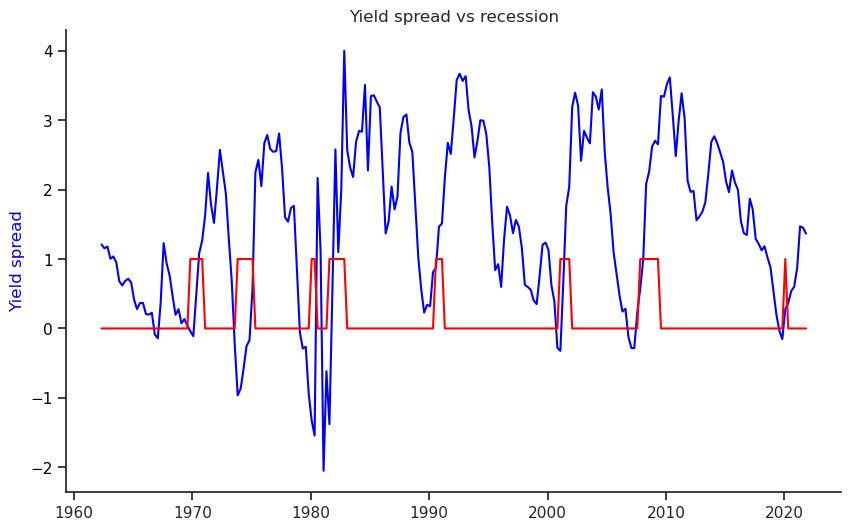

In [25]:
# plot the yield vs the recession
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(data.index, data['Yield spread_mean'], color = 'blue')
ax.plot(data.index, data['USREC'], color = 'red')
ax.set_ylabel('Yield spread', color = 'blue')
ax.tick_params(axis='y', labelcolor='black')
plt.title('Treasury vs recession')
plt.show()


#### Other data
Let us also look at the other data in our datasets to see if they are good indicators for recessions.

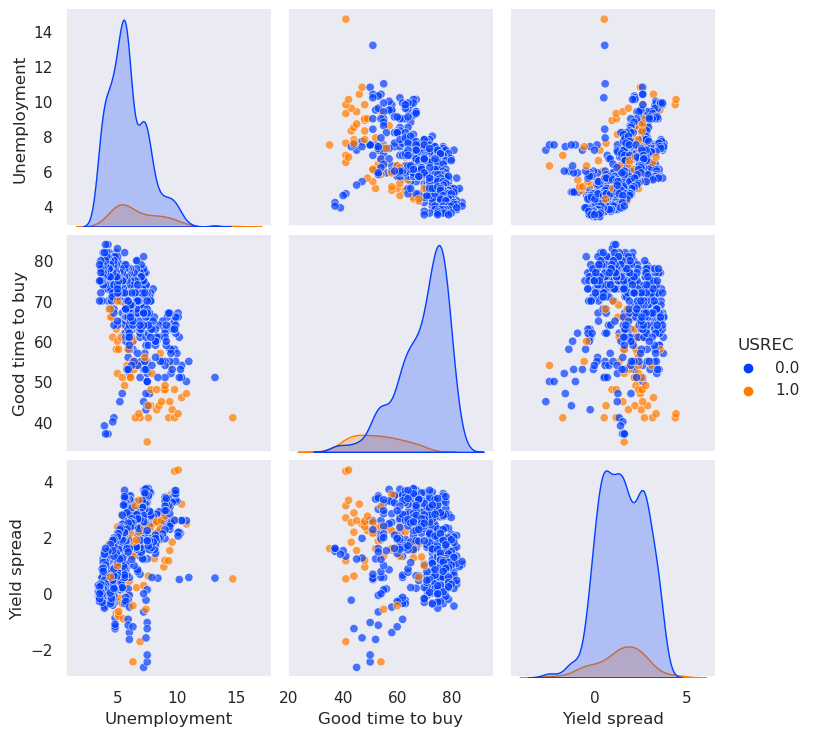

In [4]:
#sns.set(rc={'axes.facecolor':'#a8aaad', 'figure.facecolor':'#a8aaad'})
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
sns.set_palette("bright")
with sns.axes_style("dark"):

    sns.pairplot(recession_vs_yield.drop(columns = ['Value_10yr','Value_3mon', 'Uncertain - depends', 'housing market','Bad time to buy', 'Relative']), hue = 'USREC', plot_kws={'alpha': 0.7})
plt.savefig('figures/pairplots.png', transparent=True, dpi = 400, bbox_inches='tight');

### Preparing the training
We now split our data into test and train data. Our train-test split is 30%. We use sklearns train_test_split function to format everything correctly to train our different models

In [5]:
#Set the global X and y variables
X = data.drop(columns = ['USREC'])
y = data['USREC']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20, stratify=y)


### Training
Now we train 3 different model. They are all classifier models as we only want to predict wether or not a recession is about to hapen and not how bad the recession is. So the returned values are the probability of a recession instead of the severity.

The first model we train is a typical logistic regression. This performs pretty well however it can lead to overfitting very fast.

The next model is a random forest classifier. Random firest classiers are most 

In [7]:
#Logistic regression model
steps = [('imputer', SimpleImputer(strategy = 'median')), ('smote', SMOTE()),('scaler', StandardScaler()), ('rgsr', LogisticRegression(max_iter=9000))]
lr_pipe = smpipe(steps = steps)
lr_grid = [{'rgsr__C': [1e4,1e6], 'rgsr__solver': ['newton-cg', "lbfgs", 'liblinear', 'sag', 'saga']}]
lr_grid_search = GridSearchCV(estimator = lr_pipe, param_grid = lr_grid,cv = 5, scoring = 'recall')

#Random forest classifier model
steps = [('imputer', SimpleImputer(strategy = 'median')), ('smote', SMOTE()), ('scaler', StandardScaler()), ('rgsr', RandomForestClassifier())]
rf_pipe = smpipe(steps = steps)
rf_grid = [{'rgsr__n_estimators': range(50,1000,50), 'rgsr__max_depth': [2,3,4], 'rgsr__min_samples_leaf': [4]}]
rf_grid_search = GridSearchCV(estimator = rf_pipe, param_grid = rf_grid, cv = 5, scoring = 'recall')

#XGBoost classifier model
steps = [('imputer', SimpleImputer(strategy = 'median')), ('smote', SMOTE()),('scaler', StandardScaler()), ('rgsr', GradientBoostingClassifier())]
xg_pipe = smpipe(steps = steps)
xg_grid = [{'rgsr__n_estimators': range(50,1000,50)}]
xg_grid_search = GridSearchCV(estimator = xg_pipe, param_grid = xg_grid, cv = 5, scoring = 'f1')

#Fit the models
lr_grid_search.fit(X_train,y_train)
rf_grid_search.fit(X_train,y_train)
xg_grid_search.fit(X_train,y_train)

#Report accuracy
print('Logistic regression recall: ', recall_score(y_test,lr_grid_search.predict(X_test)))
print('Random forest regression recall: ', recall_score(y_test,rf_grid_search.predict(X_test)))
print('XGBoost regression recall: ', recall_score(y_test,xg_grid_search.predict(X_test)))

Logistic regression recall:  0.9
Random forest regression recall:  0.8
XGBoost regression recall:  0.7


Area under the curve logistic regression:  0.879
Area under the curve random forest:  0.8952
Area under the curve XGBoost:  0.9468


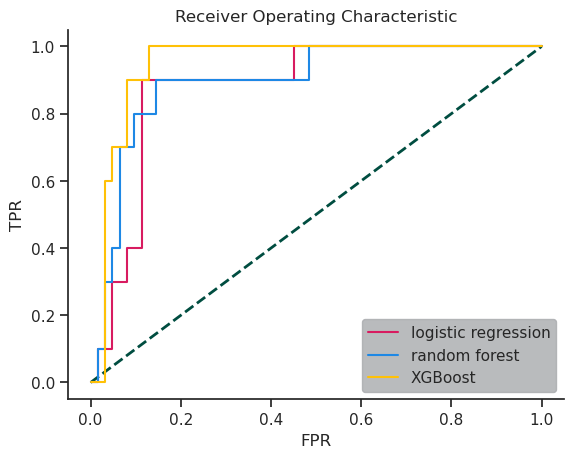

In [8]:
#For the logistic regression ROC
fpr, tpr, thresholds = roc_curve(y_test, lr_grid_search.predict_proba(X_test)[:, 1])
fig, ax = plt.subplots()
plt.plot(fpr,tpr, label = 'logistic regression', c = '#D81B60')
plt.plot([0, 1], [0, 1], color="#004D40", lw=2, linestyle="--")
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('Receiver Operating Characteristic')
aucscore = auc(fpr,tpr)
print('Area under the curve logistic regression: ',round(aucscore,4))

#For the random forest ROC
fpr, tpr, thresholds = roc_curve(y_test, rf_grid_search.predict_proba(X_test)[:, 1])
plt.plot(fpr,tpr, label = 'random forest', c = '#1E88E5')
aucscore = auc(fpr,tpr)
print('Area under the curve random forest: ',round(aucscore,4))

#For the random forest ROC
fpr, tpr, thresholds = roc_curve(y_test, xg_grid_search.predict_proba(X_test)[:, 1])
plt.plot(fpr,tpr, label = 'XGBoost', c = '#FFC107')
aucscore = auc(fpr,tpr)
print('Area under the curve XGBoost: ',round(aucscore,4))


legend = plt.legend(loc = 'best')
frame = legend.get_frame()
frame.set_color('#a8aaad')
plt.savefig('figures/ROC.png', transparent=True, dpi = 800, bbox_inches='tight');

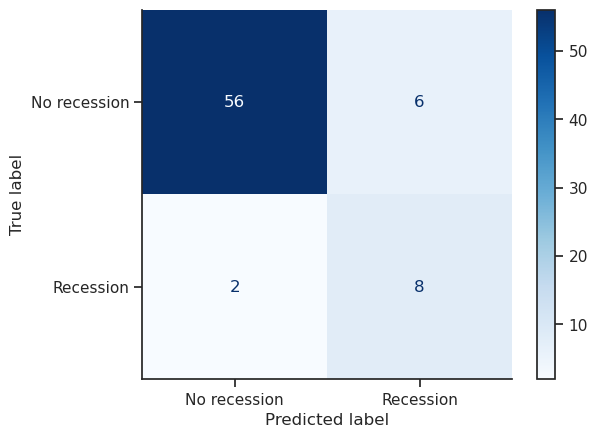

In [9]:
threshold = .5
y_probas = rf_grid_search.predict_proba(X_test)[:,1]
custom_thresh_y_pred_test = [1 if y > threshold else 0 for y in y_probas]
conf = confusion_matrix(y_test,np.array(custom_thresh_y_pred_test))
#disp = ConfusionMatrixDisplay()
disp = ConfusionMatrixDisplay.from_estimator(rf_grid_search,X_test,y_test,display_labels=('No recession','Recession'), cmap = plt.cm.Blues)
#disp.plot()
plt.savefig('figures/confMat.png', transparent=True, dpi = 800, bbox_inches='tight');

In [10]:
from sklearn.metrics import classification_report
report = classification_report(y_test,custom_thresh_y_pred_test, output_dict = True)
report;

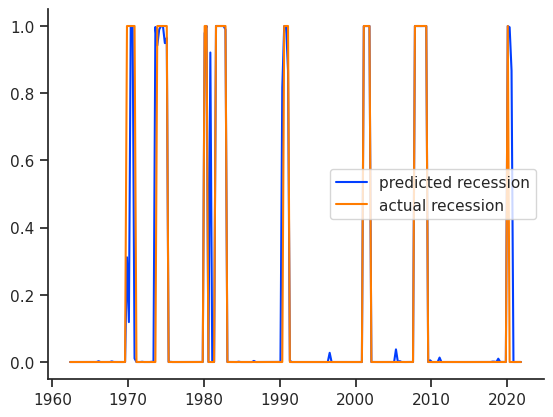

In [11]:
fig, ax = plt.subplots()

plt.plot(data.index,pd.Series(xg_grid_search.predict_proba(X)[:,1]), label = 'predicted recession')
plt.plot(data.index,data['USREC'],label = 'actual recession')
plt.legend(loc = 'best')

#plt.axis([dt.fromisoformat('1979-07-01'), dt.fromisoformat('1980-07-01'), 0, 1]);

''

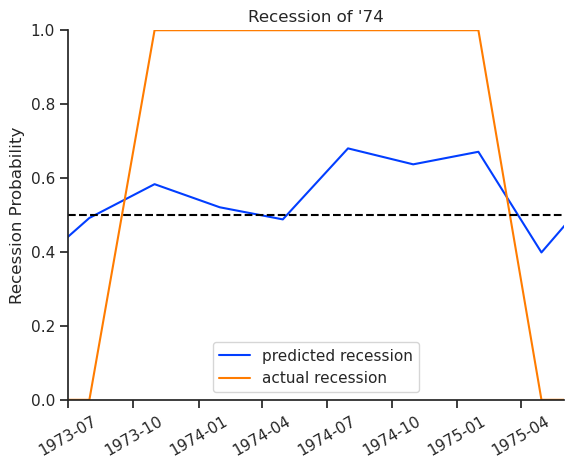

In [12]:
fig, ax = plt.subplots()

plt.plot(data.index,pd.Series(rf_grid_search.predict_proba(X)[:,1]), label = 'predicted recession')
plt.plot(data.index,data['USREC'],label = 'actual recession')
plt.legend(loc = 'best')
plt.axhline(0.5, c = 'black', linestyle = '--')
plt.xticks(rotation = 30)
plt.ylabel('Recession Probability')
plt.title('Recession of \'74')
plt.axis([dt.fromisoformat('1973-07-01'), dt.fromisoformat('1975-06-01'), 0, 1])
plt.savefig('figures/recession_of_74.png', transparent=True, dpi = 800, bbox_inches='tight')
;

''

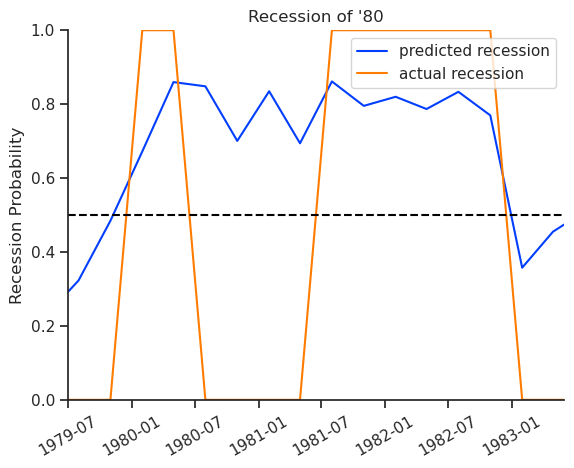

In [13]:
fig, ax = plt.subplots()

plt.plot(data.index,pd.Series(rf_grid_search.predict_proba(X)[:,1]), label = 'predicted recession')
plt.plot(data.index,data['USREC'],label = 'actual recession')
plt.legend(loc = 'best')
plt.axhline(0.5, c = 'black', linestyle = '--')
plt.xticks(rotation = 30)
plt.ylabel('Recession Probability')
plt.title('Recession of \'80')
plt.axis([dt.fromisoformat('1979-07-01'), dt.fromisoformat('1983-06-01'), 0, 1])
plt.savefig('figures/recession_of_80.png', transparent=True, dpi = 800, bbox_inches='tight')
;

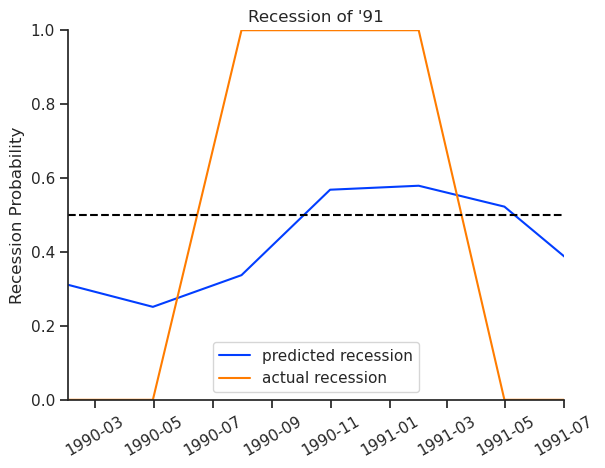

In [14]:
fig, ax = plt.subplots()

plt.plot(data.index,pd.Series(rf_grid_search.predict_proba(X)[:,1]), label = 'predicted recession')
plt.plot(data.index,data['USREC'],label = 'actual recession')
plt.legend(loc = 'best')
plt.axhline(0.5, c = 'black', linestyle = '--')
plt.xticks(rotation = 30)
plt.ylabel('Recession Probability')
plt.title('Recession of \'91')
plt.axis([dt.fromisoformat('1990-02-01'), dt.fromisoformat('1991-07-01'), 0, 1])
plt.savefig('figures/recession_of_91.png', transparent=True, dpi = 800, bbox_inches='tight');

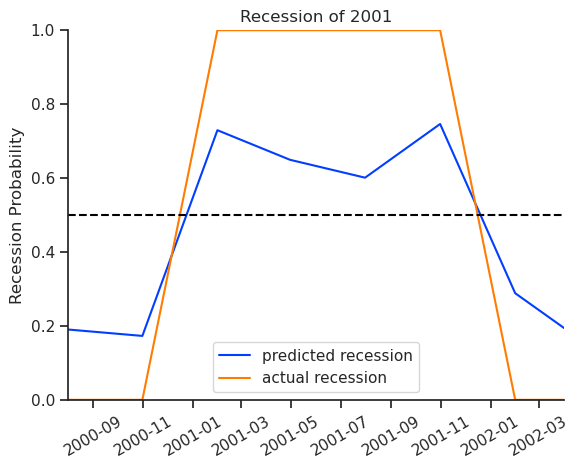

In [15]:
fig, ax = plt.subplots()

plt.plot(data.index,pd.Series(rf_grid_search.predict_proba(X)[:,1]), label = 'predicted recession')
plt.plot(data.index,data['USREC'],label = 'actual recession')
plt.legend(loc = 'best')
plt.axhline(0.5, c = 'black', linestyle = '--')
plt.xticks(rotation = 30)
plt.ylabel('Recession Probability')
plt.title('Recession of 2001')
plt.axis([dt.fromisoformat('2000-08-01'), dt.fromisoformat('2002-04-01'), 0, 1])
plt.savefig('figures/recession_of_2001.png', transparent=True, dpi = 800, bbox_inches='tight');

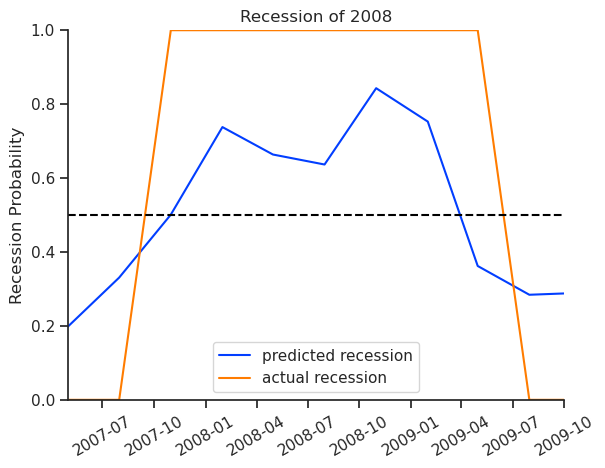

In [16]:
fig, ax = plt.subplots()

plt.plot(data.index,pd.Series(rf_grid_search.predict_proba(X)[:,1]), label = 'predicted recession')
plt.plot(data.index,data['USREC'],label = 'actual recession')
plt.legend(loc = 'best')
plt.axhline(0.5, c = 'black', linestyle = '--')
plt.xticks(rotation = 30)
plt.ylabel('Recession Probability')
plt.title('Recession of 2008')
plt.axis([dt.fromisoformat('2007-05-01'), dt.fromisoformat('2009-10-01'), 0, 1])
plt.savefig('figures/recession_of_2008.png', transparent=True, dpi = 800, bbox_inches='tight');

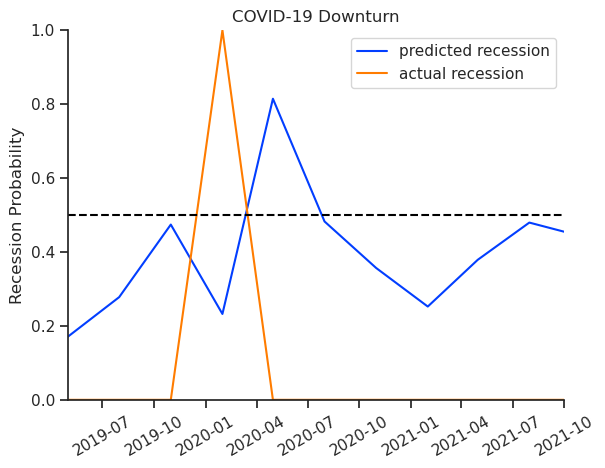

In [17]:
fig, ax = plt.subplots()

plt.plot(data.index,pd.Series(rf_grid_search.predict_proba(X)[:,1]), label = 'predicted recession')
plt.plot(data.index,data['USREC'],label = 'actual recession')

plt.legend(loc = 'best')
plt.axhline(0.5, c = 'black', linestyle = '--')
plt.xticks(rotation = 30)
plt.ylabel('Recession Probability')
plt.title('COVID-19 Downturn')
plt.axis([dt.fromisoformat('2019-05-01'), dt.fromisoformat('2021-10-01'), 0, 1])
plt.savefig('figures/COVID.png', transparent=True, dpi = 800, bbox_inches='tight');

In [18]:
#Store the model for later use
import joblib

recession = pd.DataFrame(rf_grid_search.predict_proba(X)[:,1], index = data.index, columns = ['recession'])

with open('models/recession_probs.pkl', 'wb') as f:
    joblib.dump(recession, f)